In [26]:
import csv
import numpy as np
import matplotlib.pyplot as plt

In [27]:
datafile = "recorded_sensor_data/field_data_2/auto/mocap_data-175.173.csv"
reader = csv.reader(open(datafile, 'r'))

next(reader) # skip header
data = []
for row in reader:
    data.append(list(map(float, [row[0],row[1],row[2],row[5]])))
data = np.array(data)

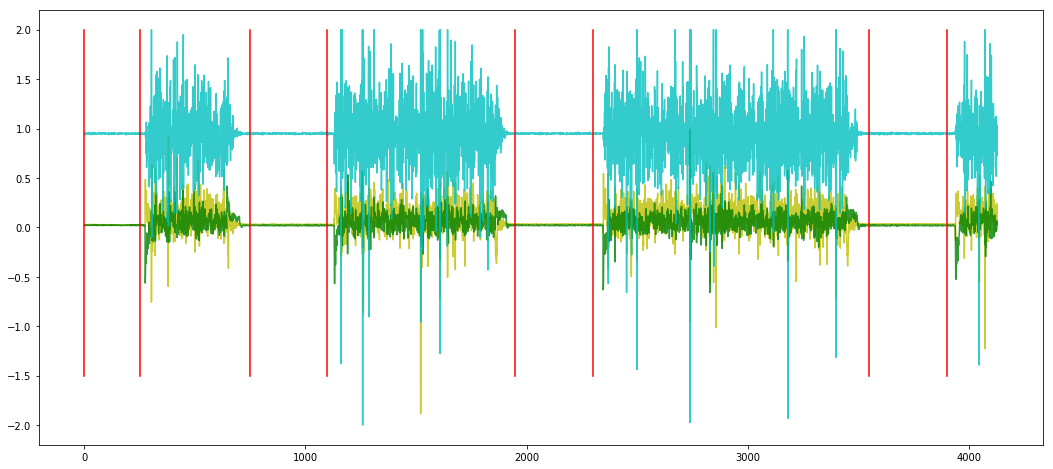

In [52]:
static_guess = [[0, 250],[750,1100],[1950,2300],[3550,3900]]

opacity = 0.8

plt.figure(figsize=(18,8))
plt.title("")
plt.plot(data[:,0] , c = 'y', alpha = opacity)
plt.plot(data[:,1] , c = 'g', alpha = opacity)
plt.plot(data[:,2] , c = 'c', alpha = opacity)
for g in static_guess:
    plt.plot([g[0],g[0]],[-1.5,2.0], c = 'r')
    plt.plot([g[1],g[1]],[-1.5,2.0], c = 'r')
plt.show()

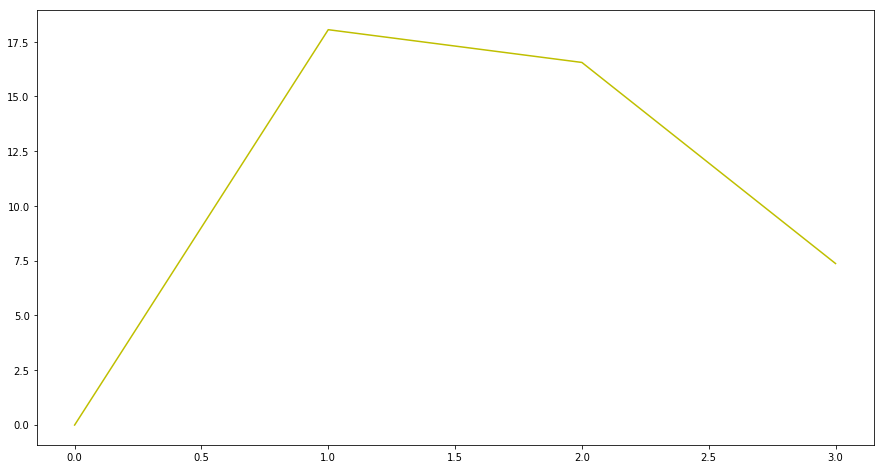

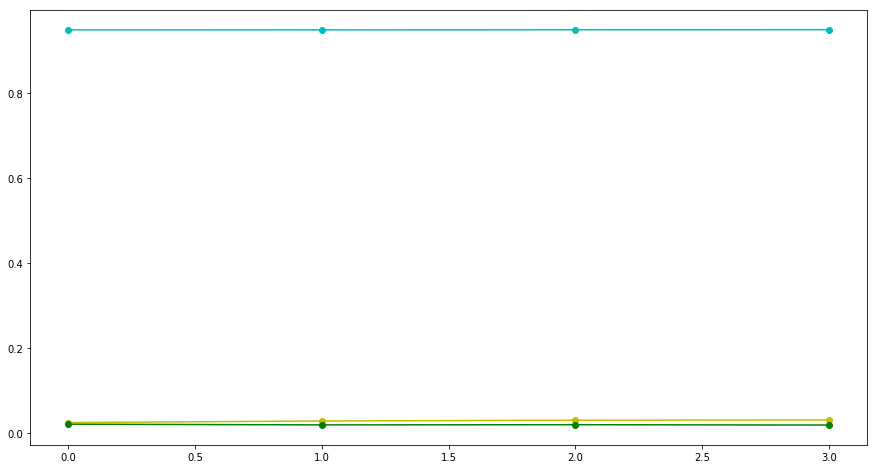

In [51]:
averages = []

for x in static_guess:
    averages.append(np.mean(data[x[0]: x[1],:], axis = 0))

averages = np.array(averages)    

plt.figure(figsize=(15,8))
plt.title("")
plt.plot(averages[:,3], c = 'y')
plt.show()

plt.figure(figsize=(15,8))
plt.title("")
plt.plot(averages[:,0], c = 'y',marker = 'o')
plt.plot(averages[:,1], c = 'g', marker = 'o')
plt.plot(averages[:,2], c = 'c', marker = 'o')
plt.show()